<a href="https://colab.research.google.com/github/Phrmth/New/blob/master/Submission_of_Twitter_Airline_ULMFiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Packages

In [0]:
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re
import os
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from sklearn.metrics import accuracy_score

# Cleaning the text reviews


In [0]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)


import re
regex = r"@(VirginAmerica|united|SouthwestAir|Delta|USAirways|AmericanAir|JetBlue)"
def text_replace(s):
    return re.sub(regex, '@airline', s, flags=re.IGNORECASE)

# Loading and exploring the data 

In [4]:
#Unzipping the files
!unzip Tweets.csv.zip -d /data
!ls /data
train_orig = pd.read_csv('/data/Tweets.csv')

Archive:  Tweets.csv.zip
  inflating: /data/Tweets.csv        
Tweets.csv


In [5]:
print("Data Shape " ,train_orig.shape)
print("Data Columns",train_orig.columns)
train_orig.head()

Data Shape  (14640, 15)
Data Columns Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


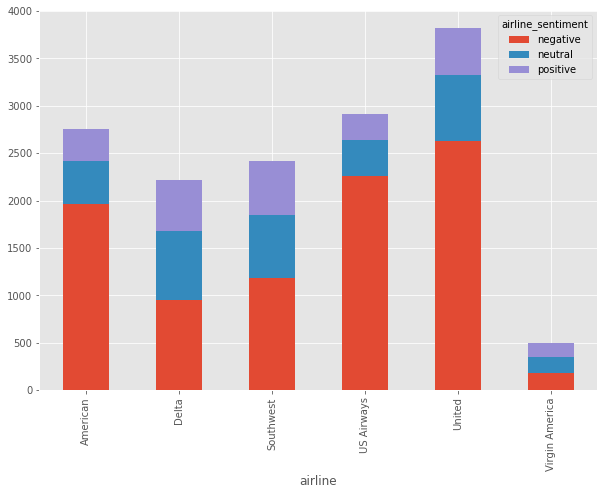

In [6]:
#Plot showing the tweet sentiments by airlines
pd.crosstab(train_orig.airline,train_orig.airline_sentiment).plot.bar(stacked=True, figsize=(10,7))

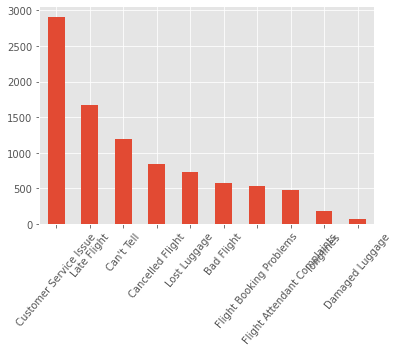

In [7]:
# Plot showing the top Negative tweet reasons
train_orig.negativereason.value_counts().plot.bar(rot=50)

Above shows missing data in the columns for negative reason, while customer service and flight delays are the the next top reasons for a negative experience

In [8]:
# Tail of the review text
train_orig['text'].tail()

14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, dtype: object

Target categories of the airline sentiments , 3 classes 

In [9]:
print("Tweet sentiments are:\n")
print("------------------------------------------")
for item in train_orig['airline_sentiment'].unique():
    print(item)

Tweet sentiments are:

------------------------------------------
neutral
positive
negative


In [0]:
# Cleaning the text and replacing the airline individual names by airline
train_orig['text'] = train_orig['text'].apply(clean_ascii)
train_orig['text'] = train_orig['text'].apply(text_replace)

In [11]:
# Picking up the required columns 
train = pd.concat([train_orig['airline_sentiment'], train_orig['text']], axis=1)
train.tail()

,airline_sentiment,text
14635,positive,@airline thank you we got on a different fligh...
14636,negative,@airline leaving over 20 minutes Late Flight. ...
14637,neutral,@airline Please bring American Airlines to #Bl...
14638,negative,"@airline you have my money, you change my flig..."
14639,neutral,@airline we have 8 ppl so we need 2 know how m...


In [12]:
# Creating the test and train data and text only data for language model 
train_orig.sort_index(inplace=True)
cutoff = int(0.1 * train_orig.shape[0])
train_orig[['airline_sentiment', 'text']][:cutoff].to_csv('Tweets_filtered_test.csv', index=False, encoding='utf-8')
train_orig[['airline_sentiment', 'text']][cutoff:].to_csv('Tweets_filtered_train.csv', index=False, encoding='utf-8')
train_orig[['text']][cutoff:].to_csv('Tweets_text_only_train.csv', index=False, encoding='utf-8')
print(train_orig[['airline_sentiment', 'text']][:cutoff].shape)
print(train_orig[['airline_sentiment', 'text']][cutoff:].shape)

(1464, 2)
(13176, 2)


In [13]:
# Train data
data = TextClasDataBunch.from_csv('.', 'Tweets_filtered_train.csv')
data.show_batch()

text,target
xxbos @airline xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag xxunk for xxup jac - xxup lax ?,neutral
xxbos @airline xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj xxunk xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @airline 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative
"xxbos @airline xxmaj thanks . xxmaj still booked our trip 3 / 13 - 17 xxup lb to xxup slc to see grand kids . xxmaj just very frustrating . xxmaj tried app , web , etc . xxmaj still love u guys !",positive
"xxbos @airline $ xxunk xxunk 4 / 30 - 5 / 5 "" xxup xxunk : xxup rt xxunk : xxmaj if you 're trying to make travel reservations for xxmaj vegas on xxmaj may 2nd it 's too xxmaj late xxmaj flight """,neutral


In [14]:
# Preprocessing
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '@airline']

Preprocessing the text by replacing the unknown, padding , repeated words, beginning of sentenses, uppercase etc..

In [15]:
# Preprocessed text reviews
print(data.train_ds[0][0])
print(data.train_ds[1][0])
print(data.train_ds[2][0])

xxbos @airline she 's the type of person that can make a customers day ! i fly 100 + times a year & & she 's one of the top flight attendants i 've had !
xxbos @airline your chairmans phone is down . what other number can i use ?
xxbos @airline we have . xxmaj twice . xxmaj they said they ca n't xxunk those lights . xxmaj but they did on our first flight .


idx,text
0,xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow xxbos @airline xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you xxbos @airline it was delivered ! xxmaj thank you for making sure it arrived at my xxunk ! xxbos @airline - rebooked
1,", xxup nj and i 'm going to xxup sfo xxbos @airline you a xxunk xxbos @airline xxmaj thanks ! xxmaj good to know . xxbos @airline okay . xxmaj thanks . xxbos @airline xxmaj conference xxunk in 3 hours . xxmaj up all night due to delays and still waiting to talk to someone about lost luggage . xxbos @airline xxmaj seat xxup xxunk , xxmaj flight xxup xxunk"
2,"to the plane . xxmaj get it together , folks . xxbos @airline xxup ua xxunk there is no way a plane "" loses its software "" i believe you decided to do an upgrade ... xxbos @airline already missed connection ... xxup ua xxunk xxbos @airline xxunk once you get the problem fixed - then the crew expires - and the delay turns into a xxmaj cancelled xxmaj flight"
3,"- xxup hou , told him my father is dying and needed to get my xxunk on the cabin . he did nothing # shameful xxbos @airline xxmaj any chance you are allowing reflight xxmaj booking xxmaj problems yet for travel out of xxmaj denver this weekend due to xxunk storm ? xxbos we all watched as the crew was xxunk from the back to 1st class . xxmaj xxunk"
4,"\n \n xxmaj except now he 's stuck on the runway in xxmaj houston . xxbos @airline thank you for getting our daughter home when @airline xxmaj cancelled xxmaj flightled all their flights to xxmaj nashville xxbos @airline thanks for the re - upgrade to 1st class . xxmaj it may be a 45 min flight , but it is appreciated . xxbos @airline makes total sense , except"


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


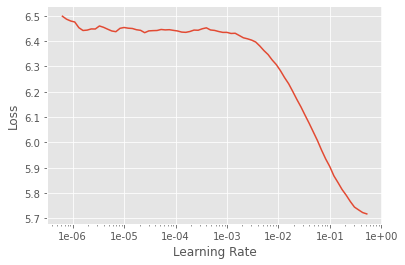

In [16]:
# Modelling with text only data for the Language Model
bs = 24
seed = 333

data_lm = (TextList.from_csv('.', 'Tweets_text_only_train.csv')
            .split_by_rand_pct(0.1, seed = seed)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

data_lm.show_batch()

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

learn.lr_find()

learn.recorder.plot(skip_end=15)

In [17]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.010561,3.729802,0.294821,00:21


In [18]:
learn.save('fit_head')
# learn.load('fit_head')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.651271,3.617146,0.312113,00:22
1,3.529061,3.523819,0.324375,00:22
2,3.386571,3.458972,0.329940,00:22
3,3.192993,3.434451,0.332500,00:22
4,2.977066,3.457118,0.331875,00:22
5,2.733308,3.497968,0.330714,00:22
6,2.524868,3.562847,0.328869,00:22
7,2.366088,3.606964,0.328155,00:22
8,2.242614,3.639286,0.327411,00:22
9,2.181490,3.654886,0.326161,00:22


In [19]:
# Predict the language model 
print(learn.predict('My flight is great!', n_words=50))

# Predict the language model 
print(learn.predict('delayed flight', n_words=50))

My flight is great! ! ! This is my best trip customer service ever ! @airline ! i like to go ! xxbos @airline jetblue ... that link does n't work ! http : / / t.co / DEN xxbos @airline Done . xxbos @airline well i 'm going to entertain
delayed flight offices at Reagan Airport DFW for over an hour http : / / t.co / 6 xxbos find please process we [ raise ] a minute for our 3 nice year old ; still do n't understand why we ca n't wait xxbos @airline Definitely !


In [0]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

In [21]:
data_clas = (TextList.from_csv('.', 'Tweets_filtered_train.csv', cols = 'text')               
             .random_split_by_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


text,target
xxbos @airline xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @airline xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to xxunk it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @airline xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,negative
"xxbos @airline ( 2 / 2 ) xxmaj it xxunk that if ca n't confirm xxunk at time of xxmaj flight xxmaj booking xxmaj problems , i should assume that it may never clear . xxmaj did n't used to be that way",negative
xxbos @airline xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ? ?,negative


In [22]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11859 items)
x: TextList
xxbos @airline the delay is due to customer service for 20 people ? xxmaj what about the xxup xxunk - xxup service you provided for 100 + ? # xxunk # xxunk,xxbos @airline he is so excellent and so reliable :) # happycustomer,xxbos @airline but again xxup united xxup xxunk xxup give 2 xxup xxunk xxup about xxup their xxup customers,xxbos @airline xxmaj she is travelling from xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow,xxbos @airline xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you
y: CategoryList
negative,positive,negative,neutral,neutral
Path: .;

Valid: LabelList (1317 items)
x: TextList
xxbos @airline stuck on xxmaj tarmac for 30 mins at xxup phl waiting for someone to load baggage , ridiculous http : / / t.co / xxunk,xxbos @airline i consider myself a loyal c

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


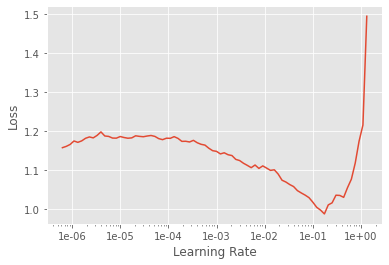

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.669472,0.532582,0.792711,00:25


In [0]:
learn.save('first')
# learn.load('first)

In [26]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.637987,0.509737,0.804100,00:27


In [0]:
learn.save('second')
# learn.load('second')

In [28]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.572455,0.475641,0.817768,00:28


In [29]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.480511,0.458689,0.820046,00:29
1,0.433942,0.469228,0.813212,00:29
2,0.414824,0.457601,0.815490,00:30


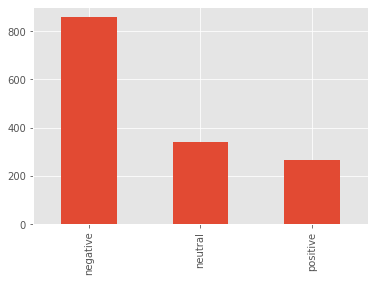

In [30]:
test_df = pd.read_csv("Tweets_filtered_test.csv", encoding="utf-8")
test_df['airline_sentiment'].value_counts().plot(kind='bar')

In [31]:

test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.799863387978142


In [32]:
pd.crosstab(test_df['pred_sentiment'], test_df['airline_sentiment'])


airline_sentiment,negative,neutral,positive
pred_sentiment,,,
negative,788,98,59
neutral,51,210,34
positive,20,31,173


In [33]:
# Wrongly predicted tweets
test_df[test_df.pred_sentiment != test_df.airline_sentiment]

,airline_sentiment,text,pred_sentiment
1,positive,@airline plus you've added commercials to the ...,negative
2,neutral,@airline I didn't today... Must mean I need to...,negative
6,positive,"@airline yes, nearly every time I fly VX this ...",negative
7,neutral,@airline Really missed a prime opportunity for...,negative
8,positive,"@airline Well, I didn'tbut NOW I DO! :-D",neutral
...,...,...,...
1438,negative,@airline I lost my sunglasses on the flight fr...,neutral
1439,neutral,@airline @reccewife with the exception of ever...,negative
1440,negative,@airline UA1731 - Denver to Austin... Still o...,neutral
1443,negative,@airline considering it. Currently gold on @ai...,neutral


In [0]:
#OLD 

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(train, stratify = train['airline_sentiment'], test_size = 0.3, random_state = 12)

In [35]:
df_trn.shape, df_val.shape


((10248, 2), (4392, 2))

In [36]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [37]:
#data_lm.show_batch()
data_lm.train_ds.vocab

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)
                               #arch=AWD_LSTM, drop_mult=0.1)

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [40]:
list(learn.model.children())
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.944701,4.122048,0.239444,00:14


In [0]:
learn.save_encoder('ft_enc')
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.7)
#learn.load_encoder('ft_enc')

In [42]:
learn.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.914248,0.924954,0.626822,00:20


In [43]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.666871,0.555789,0.782104,00:22
1,0.523472,0.490431,0.806466,00:23
2,0.412219,0.487957,0.816940,00:23


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


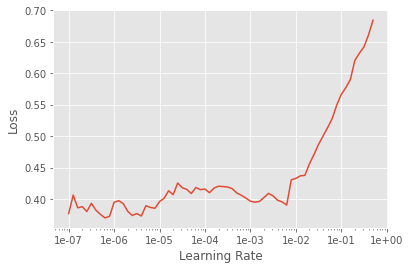

In [44]:

learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [45]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,2516,261,131
1,176,577,83
2,61,92,495


In [0]:
learn.save_encoder('ft_enc')

In [47]:
learn.load_encoder('ft_enc')
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.383065,0.530049,0.804645,00:19


In [0]:
learn.save_encoder('second')
learn.load_encoder('second')
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [0]:
# Topic Modelling for the Airline sentiments 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tf_vectorizer = CountVectorizer(max_df=.9,min_df = 25,max_features= 1000)
tf = tf_vectorizer.fit_transform(train_orig['text'].values.astype('U'))
tf_featurenames = tf_vectorizer.get_feature_names()

In [0]:
doc_term_matrix = pd.DataFrame(tf.toarray(),columns= list(tf_featurenames))
doc_term_matrix

In [0]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components= 5,learning_method = 'online',max_iter=100,random_state = 0).fit(tf)

In [0]:
n_top = 10

def display_topics(model,feature_names, n_top):
  for topic_idx,topic in enumerate(model.components_):
    print("Topid %d",topic_idx)
    print(" ".join([feature_names[i] 
     for i in topic.argsort()[: - n_top - 1:- 1]]))

display_topics(lda_model,tf_featurenames,n_top)